# Assignment 2 machine-learning

Predict stock market price for TESLA. I want you to make a prediction algorithm which predicts the price of this stock on a specific date. Input will be date and output should be price of that stock (close value in the data file). You should also show the prediction percentage score. Data file: TESLA.csv For updated csv file, please download the data from: https://finance.yahoo.com/quote/TSLA/history?p=TSLA

In [4]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


In [5]:
url = os.path.join("TSLA.csv")
df = pd.read_csv(url, sep=",")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-01,234.050003,237.399994,227.279999,227.820007,227.820007,62688800
1,2022-11-02,226.039993,227.869995,214.820007,214.979996,214.979996,63070300
2,2022-11-03,211.360001,221.199997,210.139999,215.309998,215.309998,56538800
3,2022-11-04,222.600006,223.800003,203.080002,207.470001,207.470001,98622200
4,2022-11-07,208.649994,208.899994,196.660004,197.080002,197.080002,93916500


In [6]:
# Create a new feature "Day" that will be number of days after 
# the first day in the dataset

#Converting date to unix time
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d").map(pd.Timestamp.timestamp).astype(int)
#Gets the first day to get days from the start
first_day = df['Date'][0]
#Date - (first_date) then converting seconds to days (60 seconds in a minute * 60 minutes in a hour * 24 hours in  a day )
df['Day'] = (df['Date'] - 1666742400) // (60*60*24)

In [7]:
#Shows correlation between the different values
corrMatrix = df.corr()
#Same but in a matrix
corrMatrix.style.background_gradient(cmap='coolwarm')

,Date,Open,High,Low,Close,Adj Close,Volume,Day
Date,1.000000,0.717062,0.718282,0.727208,0.724515,0.724515,-0.216566,1.000000
Open,0.717062,1.000000,0.996697,0.996496,0.990525,0.990525,-0.333659,0.717062
High,0.718282,0.996697,1.000000,0.997200,0.996165,0.996165,-0.308897,0.718282
Low,0.727208,0.996496,0.997200,1.000000,0.996696,0.996696,-0.343211,0.727208
Close,0.724515,0.990525,0.996165,0.996696,1.000000,1.000000,-0.319599,0.724515
Adj Close,0.724515,0.990525,0.996165,0.996696,1.000000,1.000000,-0.319599,0.724515
Volume,-0.216566,-0.333659,-0.308897,-0.343211,-0.319599,-0.319599,1.000000,-0.216566
Day,1.000000,0.717062,0.718282,0.727208,0.724515,0.724515,-0.216566,1.000000


# Training

We are dealing with continuous data, so we will use a regression algorithm.

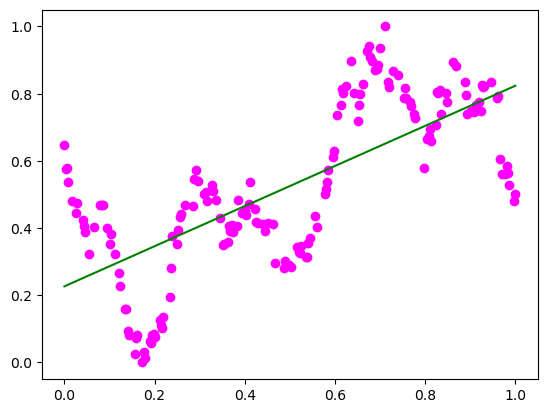

In [8]:
# Input will be day and the output will be the close price.
X = pd.DataFrame(df["Day"])
y = pd.DataFrame(df["Close"])

# Scaling date and close price with a MinMax (between 0 and 1)
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()
X = sc_X.fit_transform(np.array(X))
y = sc_y.fit_transform(np.array(y))

# Dividing between a training and testing set. Test_size means that we are using 67% 
# of the dataset to training and 33% to the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

# With train_test_split the data was shuffled. That means our data (days) are out of order.
# We sort the dates, and use zip to also sort the y-values. 
X_train,y_train = zip(*sorted(zip(X_train,y_train)))
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Do the same for test set
X_test,y_test = zip(*sorted(zip(X_test,y_test)))
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# We try to create a model with linear regression first, we can clearly see that this 
# does not fit the data set very well.
linear_regressor = LinearRegression()
LinearRegression()  # create object for the class
linear_regressor.fit(X_train, y_train)  # perform linear regression
Y_pred = linear_regressor.predict(X_train)  # make predictions

# Plotting the actual data, with the prediction line.
plt.scatter(X_train, y_train, color = 'magenta')
plt.plot(X_train, Y_pred, color = 'green')
plt.show()

In [9]:
# We will use a polynomial function instead. 
# This fits much more to what the dataset represents.
regressor = SVR(kernel='rbf')
regressor.fit(X_train,y_train.ravel())
Y_pred = regressor.predict(X_train)

MSE = 379.6820887319006


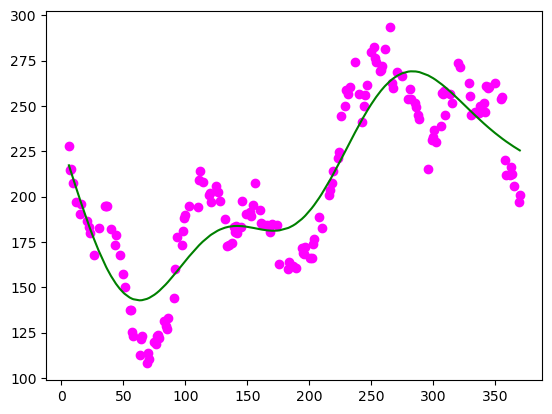

In [10]:
# Inverse the scale
X_train = sc_X.inverse_transform(np.array(X_train))
y_train = sc_y.inverse_transform(np.array(y_train))
Y_pred = np.reshape(Y_pred, (-1,1))
Y_pred = sc_y.inverse_transform(np.array(Y_pred))
# Plot actual data, with the prediction line.
plt.scatter(X_train,y_train,color = 'magenta')
plt.plot(X_train,Y_pred, color = 'green')

print( "MSE = "+str(metrics.mean_squared_error(y_train,Y_pred))) #Calculate MSE

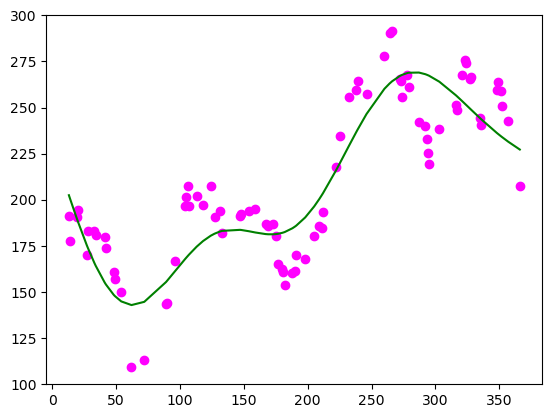

MSE = 397.33722340499344


In [11]:
#Prediciton with scaled values
Y_pred = regressor.predict(X_test)  # Predict the model on X_test

# Inverse scale of test data
X_test = sc_X.inverse_transform(np.array(X_test))
y_test = sc_y.inverse_transform(np.array(y_test))
Y_pred = np.reshape(Y_pred, (-1,1))
Y_pred = sc_y.inverse_transform(np.array(Y_pred))

# Plot
plt.scatter(X_test, y_test, color = 'magenta')
plt.plot(X_test, Y_pred, color = 'green')
plt.show()

print( "MSE = "+str(metrics.mean_squared_error(y_test,Y_pred))) #Calculate MSE

In [12]:
def inverse_scaled_y(price):
    _min = df["Close"].min()
    _max = df["Close"].max()
    return price * (_max-_min) + _min

# my_predict_date takes in a date as a string. 
# outputs predicted stock price
def my_predict_date(date):
    # Start day ( from the dataset )
    start_day = pd.to_datetime("2022-10-26", format="%Y-%m-%d").timestamp()
    # Convert date to unixtime.
    now = pd.to_datetime(date, format="%Y-%m-%d").timestamp()
    delta_days = (now-start_day) / (24*60*60)
    # predict function will expect a scaled value. ( range 0,1)
    # scaled value is: delta_days/365
    scaled_close = regressor.predict(np.array([[delta_days / 365]]))
    # Inverse the the scaled_close value before return
    return inverse_scaled_y(scaled_close)

# my_predict_days takes the day number after the first day that will be predicted. 
# outputs predicted stock price
def my_predict_day(day):
    scaled_close = regressor.predict(np.array([[day / 365]]))
    # Inverse the the scaled_close value before return
    return inverse_scaled_y(scaled_close)
    

In [13]:
# The functions can be used like this:
# Predict stock price at specific date:
print(my_predict_date("2023-10-31"))
print(my_predict_day(370))

[223.59867071]
[223.59867071]


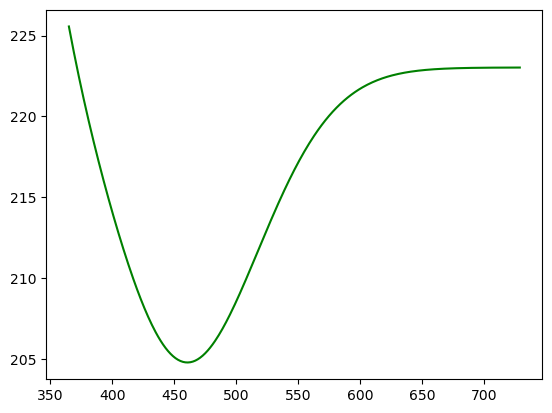

In [14]:
# Plot the prediction line for one year after our dataset.


#Makes two arrays, one for future days and another for prices
future_days = []
future_price = []
#For loop that adds our predicted prices for the next year
for i in range(365,365*2):
    future_days.append(i)
    future_price.append(my_predict_day(i))

#plot the next year of predictions
plt.plot(np.array(future_days), np.array(future_price), color = 'green')

plt.show()